In [8]:
import sys
sys.path.append('/Users/jpnousu/pyAPES_main')
import pandas as pd
import matplotlib.pyplot as plt

from pyAPES.utils.iotools import read_forcing
from pyAPES.soil.soil import Soil_1D
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters
from pyAPES.utils.constants import WATER_DENSITY

In [9]:
# Creating ForestFloor
forestfloor = ForestFloor(cpara['forestfloor'])

# Creating Soil_1D
soil = Soil_1D(spara)

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = r'/Users/jpnousu/pyAPES_main/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-06-01'

/Users/jpnousu/pyAPES_main/pyAPES/bottomlayer/organiclayer.py:1172: RuntimeWarning: invalid value encountered in power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m


In [10]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Prec_liquid'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Prec_ice'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)

In [11]:
# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
ff_res = pd.DataFrame()
s_res = pd.DataFrame()

for index, row in forcing.iterrows():

    ###### Inputs for forestfloor (based on how they are used in mlm_canopy.py)
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tdaily'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'soil_temperature': 0, # Soil temperature [degC]
        'soil_water_potential': soil.water.h[0],
        'soil_volumetric_water': soil.heat.Wliq[0],
        'soil_volumetric_air': soil.heat.Wair[0],
        'soil_pond_storage': soil.water.h_pond
    }
    ff_params = {
        'soil_thermal_conductivity': soil.heat.thermal_conductivity[0],
        'soil_hydraulic_conductivity': soil.water.Kvsat[0],
        'soil_depth': soil.grid['dz'][0],
        'reference_height': 2.0,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    # --- update forestfloor
    forestfloor.update()

    ###### Inputs for soil (based on how they are used in pyAPES_MLM.py)
    s_forcing = {
        'potential_infiltration': ff_fluxes['throughfall'] / WATER_DENSITY,
        'potential_evaporation': (ff_fluxes['soil_evaporation'] + ff_fluxes['capillary_rise']) / WATER_DENSITY,
        'pond_recharge': ff_fluxes['pond_recharge'] / WATER_DENSITY,
        'atmospheric_pressure_head': -1.0E6, # [m]
        'ground_heat_flux': -ff_fluxes['ground_heat'],
        'date': index
    }

    '''
    water_sink = None   # (array or None): water sink from layers, e.g. root sink [m s-1]
                        #   array length can be only root zone or whole soil profile
                        # if None set to zero
    heat_sink = None    # (array or None): heat sink from layers [W m-3??]
    lbc_water = None    # (dict or None): allows boundary to be changed in time
                        # 'type': 'impermeable', 'flux', 'free_drain', 'head'
                        # 'value': give for 'head' [m] and 'flux' [m s-1]
    lbc_heat = None     # (dict or None): allows boundary to be changed in time
    '''
    
    s_fluxes, s_states = soil.run(
                dt=gpara['dt'],
                forcing=s_forcing,
                water_sink=water_sink,
                heat_sink=heat_sink,
                lbc_water=lbc_water,
                lbc_heat=lbc_heat
                )
    
    # --- update soil
    s_states.update(s_fluxes)
    
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()}, 
        **{f'ff_{key}': value for key, value in ff_states.items()},
        **{f's_temp': s_states['temperature'][0]},
        **{f's_vwc': s_states['volumetric_water_content'][0]},
    }

    # Append the combined results to the results DataFrame
    ff_res = pd.concat([ff_res, pd.DataFrame([combined_results])], ignore_index=True)

ff_res.set_index('time', inplace=True)

/Users/jpnousu/pyAPES_main/pyAPES/bottomlayer/organiclayer.py:1172: RuntimeWarning: invalid value encountered in power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
/Users/jpnousu/pyAPES_main/pyAPES/bottomlayer/organiclayer.py:1114: RuntimeWarning: invalid value encountered in power
  relative_diffusivity = (np.power(Ta / 293.16, 1.75) * np.power(afp, 10.0/3.0) / porosity**2)


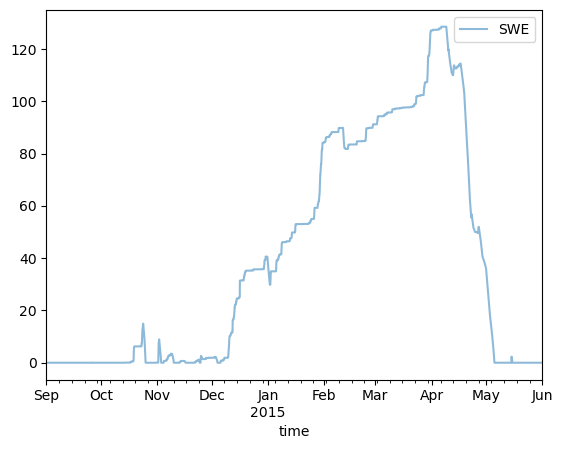

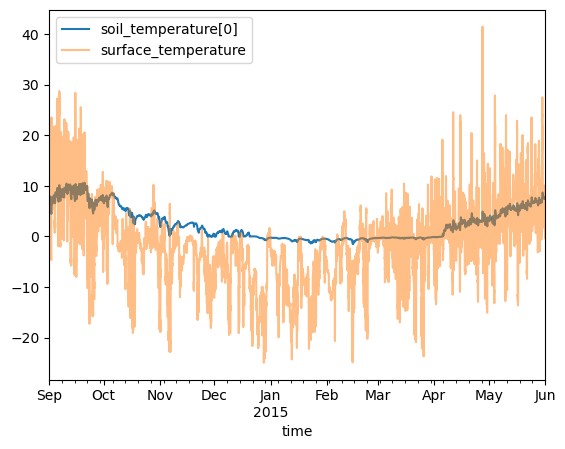

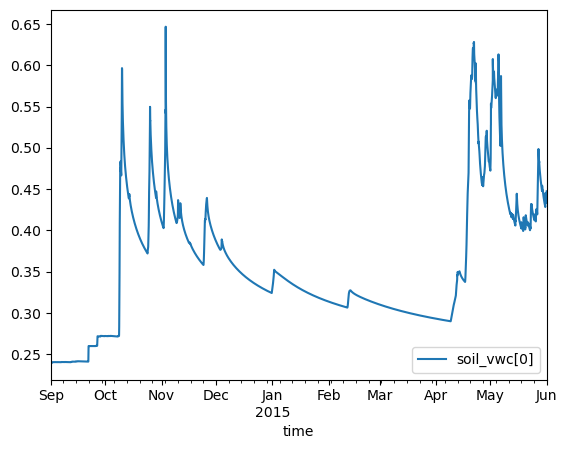

In [13]:
plt.figure(1)
ff_res['ff_snow_water_equivalent'].plot(alpha=0.5, label='SWE')
plt.legend()
plt.figure(2)
ff_res['s_temp'].plot(label='soil_temperature[0]')
ff_res['ff_surface_temperature'].plot(label='surface_temperature', alpha=0.5)
plt.legend()
plt.figure(3)
ff_res['s_vwc'].plot(label='soil_vwc[0]')
plt.legend()